# Класифікація за допомогою стекінгу, бустінгу та беггінгу


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV


## Завантаження та аналіз датасету

In [19]:
data = pd.read_csv('auction-verification/data.csv')

display(data.head())
display(data.info())
display(data.describe())

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.result,verification.time
0,0,0,2,1,59,1,0,False,163.316667
1,0,0,2,1,59,2,0,False,200.860000
2,0,0,2,1,59,4,0,False,154.888889
3,0,0,2,1,59,6,0,False,108.640000
4,0,0,2,1,60,1,0,True,85.466667


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   process.b1.capacity  2043 non-null   int64  
 1   process.b2.capacity  2043 non-null   int64  
 2   process.b3.capacity  2043 non-null   int64  
 3   process.b4.capacity  2043 non-null   int64  
 4   property.price       2043 non-null   int64  
 5   property.product     2043 non-null   int64  
 6   property.winner      2043 non-null   int64  
 7   verification.result  2043 non-null   bool   
 8   verification.time    2043 non-null   float64
dtypes: bool(1), float64(1), int64(7)
memory usage: 129.8 KB


None

,process.b1.capacity,process.b2.capacity,process.b3.capacity,process.b4.capacity,property.price,property.product,property.winner,verification.time
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000
mean,1.000000,2.093979,1.883994,0.587861,71.473324,3.252080,0.455213,7336.944574
std,0.816696,0.811269,0.320310,0.492340,8.048740,1.804225,1.062828,10375.393650
min,0.000000,0.000000,1.000000,0.000000,59.000000,1.000000,0.000000,77.916667
25%,0.000000,1.000000,2.000000,0.000000,65.000000,2.000000,0.000000,546.818910
50%,1.000000,2.000000,2.000000,1.000000,70.000000,3.000000,0.000000,1316.983333
75%,2.000000,3.000000,2.000000,1.000000,78.000000,5.000000,0.000000,10876.638889
max,2.000000,3.000000,2.000000,1.000000,90.000000,6.000000,4.000000,44130.520833


## Фічеінженіринг

In [20]:
# Ця фіча розраховує загальну потужність всіх етапів процесу.
# Об'єкти з вищою загальною потужністю можуть мати кращий результат перевірки, а це корисно для моделі класифікації.
data['capacity_sum'] = data[['process.b1.capacity', 'process.b2.capacity', 'process.b3.capacity', 'process.b4.capacity']].sum(axis=1)

# Ця фіча розраховує різницю між потужністю останнього (process.b4.capacity) та першого (process.b1.capacity) етапів.
# Ця різниця може вказувати на зміни або втрати потужності протягом процесу, що може бути індикатором результату перевірки.
data['capacity_diff'] = data['process.b4.capacity'] - data['process.b1.capacity']

# Перетворює булеву змінну verification.result (значення True/False) у числовий формат (0/1).
# Більшість алгоритмів машинного навчання потребують числових цільових змінних, тому це необхідно для коректного навчання моделей.
if data['verification.result'].dtype == 'bool':
    data['verification.result'] = data['verification.result'].astype(int)

## Підготовка фічей та цільової змінної

In [21]:
# Розділяємо фічі та цільову змінну
# X — це матриця фічей, яка містить всі колонки, крім 'verification.result', що є нашою цільовою змінною.
# y — це цільова змінна, яка містить результати перевірки (0 або 1).
X = data.drop(columns=['verification.result'])
y = data['verification.result']

# Масштабуємо фічі
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Поділ на вибірки

In [22]:
# Поділ даних на тренувальну, валідаційну та тестову вибірки

# Спочатку ділимо дані на тренувальну частину (60% даних) та тимчасову частину (40% даних).
# X_train та y_train — це тренувальні дані, які будуть використовуватись для навчання моделі.
# X_temp та y_temp — тимчасова вибірка, яка містить решту даних і ділиться на валідаційну та тестову частини.
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Ділимо тимчасову вибірку навпіл, отримуючи валідаційну (20%) та тестову (20%) вибірки.
# X_val та y_val — валідаційна вибірка, яка використовується для налаштування моделі (наприклад, підбору гіперпараметрів).
# X_test та y_test — тестова вибірка, яка використовується лише для фінальної оцінки моделі.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Навчання базових моделей

In [23]:
# Навчання моделі Random Forest (Беггінг)
# Random Forest — ансамблева модель, яка використовує метод беггінгу. 
# Вона будує багато дерев рішень на різних підвибірках даних і обчислює середнє значення (або проводить голосування) для остаточного прогнозу.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Навчання моделі Gradient Boosting Classifier (Бустінг)
# Gradient Boosting — це метод бустінгу, який по черзі додає нові слабкі моделі (зазвичай дерева), 
# щоб поступово зменшувати помилки, зроблені попередніми моделями.
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Навчання моделі Logistic Regression для стекінгу
# Логістична регресія використовується як базова модель для стекінгу.
# У стекінгу модель об'єднує прогнози кількох базових моделей (наприклад, Random Forest і Gradient Boosting),
# щоб отримати кращий кінцевий прогноз.

# Фінальний естіматор
final_estimator = LogisticRegression(C=1.0, solver='liblinear', random_state=42)

# Базові моделі
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
]



# Стекінг
stack_model = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator)
stack_model.fit(X_train, y_train)

# Прогнозування та оцінка
y_pred_stacking = stack_model.predict(X_test)
print("Точність стекінгу:", accuracy_score(y_test, y_pred_stacking))
print("Звіт класифікації для стекінгу:")
print(classification_report(y_test, y_pred_stacking))


Точність стекінгу: 0.9902200488997555
Звіт класифікації для стекінгу:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       344
           1       0.94      1.00      0.97        65

    accuracy                           0.99       409
   macro avg       0.97      0.99      0.98       409
weighted avg       0.99      0.99      0.99       409



## Оцінка

In [24]:
# Оцінюємо продуктивність моделей
# zip: Поєднує моделі та їх назви в один об'єкт для ітерації.
for model, name in zip([rf_model, gb_model, stack_model], ['Random Forest', 'Gradient Boosting', 'Stacking']):
    # Отримуємо передбачення моделі на валідаційній вибірці
    y_pred = model.predict(X_val)
    
    # Точність моделі
    print(f"{name} Accuracy: {accuracy_score(y_val, y_pred)}")
    
    # Звіт про класифікацію
    print(classification_report(y_val, y_pred))


Random Forest Accuracy: 0.9951100244498777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       369
           1       0.97      0.97      0.97        40

    accuracy                           1.00       409
   macro avg       0.99      0.99      0.99       409
weighted avg       1.00      1.00      1.00       409

Gradient Boosting Accuracy: 0.9951100244498777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       369
           1       0.97      0.97      0.97        40

    accuracy                           1.00       409
   macro avg       0.99      0.99      0.99       409
weighted avg       1.00      1.00      1.00       409

Stacking Accuracy: 0.9951100244498777
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       369
           1       0.97      0.97      0.97        40

    accuracy                           1.00       409


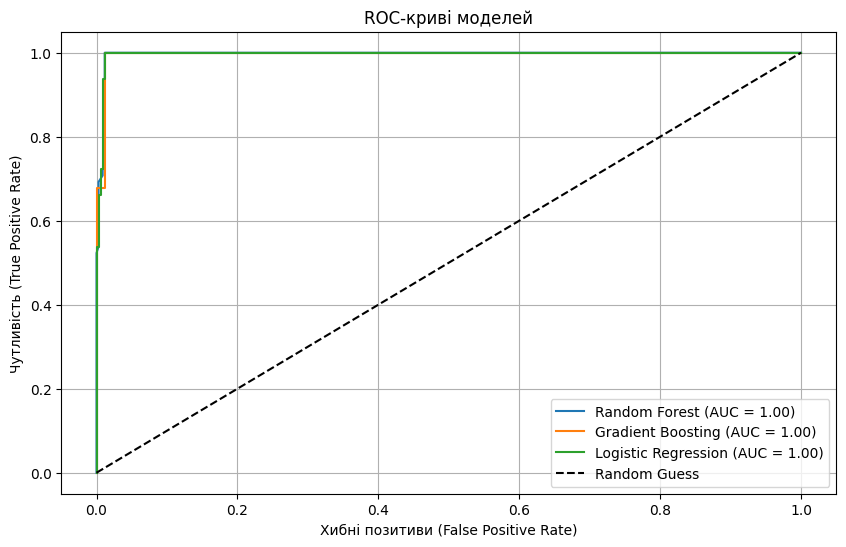

In [25]:
# Побудова ROC-кривих для моделей
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    for model, name in models:
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title("ROC-криві моделей")
    plt.xlabel("Хибні позитиви (False Positive Rate)")
    plt.ylabel("Чутливість (True Positive Rate)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Список моделей для оцінки
models = [
    (rf_model, "Random Forest"),
    (gb_model, "Gradient Boosting"),
    (stack_model, "Logistic Regression")
]

plot_roc_curves(models, X_test, y_test)


Random Forest і Gradient Boosting:

- Обидві моделі мають AUC = 1.00, що свідчить про ідеальну класифікацію (відсутність помилок на тестових даних).
- Криві обох моделей прямують до верхнього лівого кута, що означає високу чутливість і специфічність.

Logistic Regression (у стекінгу):

- Модель також має AUC = 1.00, що є несподівано високим результатом.
- Це свідчить про те, що стекінг з Logistic Regression як фінальним естіматором ефективно поєднує результати базових моделей.
- Logistic Regression, виконуючи роль мета-класифікатора в стекінгу, не поступається іншим моделям.


## Підбір гіперпараметрів

In [26]:
# Random Forest: Підбір гіперпараметрів
rf_params = {
    'n_estimators': [50, 100, 200],  # Кількість дерев
    'max_depth': [None, 10, 20, 30],  # Глибина дерев
    'min_samples_split': [2, 5, 10],  # Мінімальна кількість зразків для поділу вузла
    'min_samples_leaf': [1, 2, 4]  # Мінімальна кількість зразків у листовому вузлі
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    cv=5,  # Перехресна перевірка на 5 фолдах
    scoring='accuracy',
    n_jobs=-1  # Використовує всі доступні ядра процесора
)
rf_grid.fit(X_train, y_train)

print("Найкращі параметри для Random Forest:", rf_grid.best_params_)
print("Найкраща точність:", rf_grid.best_score_)

# Gradient Boosting: Підбір гіперпараметрів
gb_params = {
    'n_estimators': [50, 100, 200],  # Кількість дерев
    'learning_rate': [0.01, 0.1, 0.2],  # Швидкість навчання
    'max_depth': [3, 5, 7],  # Глибина дерев
    'subsample': [0.8, 1.0]  # Частка зразків для навчання кожного дерева
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)

print("Найкращі параметри для Gradient Boosting:", gb_grid.best_params_)
print("Найкраща точність:", gb_grid.best_score_)

# Logistic Regression: Підбір гіперпараметрів
logreg_params = [
    {
        'penalty': ['l1'],  # l1 регуляризація
        'C': [0.1, 1.0, 10.0],
        'solver': ['liblinear', 'saga'],  # Підтримувані оптимізатори для l1
        'max_iter': [1000, 5000, 10000]
    },
    {
        'penalty': ['l2'],  # l2 регуляризація
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear', 'saga'],  # Підтримувані оптимізатори для l2
        'max_iter': [1000, 5000, 10000]
    },
    {
        'penalty': ['elasticnet'],  # elasticnet регуляризація
        'C': [0.1, 1.0, 10.0],
        'solver': ['saga'],  # saga підтримує elasticnet
        'max_iter': [1000, 5000, 10000],
        'l1_ratio': [0.1, 0.5, 0.9]  # Співвідношення для elasticnet
    }
]

logreg_grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=logreg_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

logreg_grid.fit(X_train, y_train)

print("Найкращі параметри для Logistic Regression:", logreg_grid.best_params_)
print("Найкраща точність:", logreg_grid.best_score_)



Найкращі параметри для Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Найкраща точність: 0.9942857142857143
Найкращі параметри для Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Найкраща точність: 0.9983673469387755
Найкращі параметри для Logistic Regression: {'C': 1.0, 'l1_ratio': 0.9, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga'}
Найкраща точність: 0.889795918367347


Висновки:
- Random Forest, Gradient Boosting і Stacking показують ідеальну точність і гарну продуктивність для обох класів.